In [1]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, Utils
from SimPEG import DataMisfit, Inversion, Regularization, Problem, Survey
from SimPEG.Utils import mkvc
import numpy as np
import scipy as sp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create simple mesh with topo
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 15), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 15), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 7), (3.5, 1), (2, 5)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# Lets create a simple Gaussian topo and set the active cells
[xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
zz = -np.exp((xx**2 + yy**2) / 75**2) + mesh.vectorNz[-2]

# We would usually load a topofile
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Go from topo to actv cells
actv = Utils.surface2ind_topo(mesh, topo, 'N')
actv = np.asarray([inds for inds, elem in enumerate(actv, 1) if elem],
                  dtype=int) - 1

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, 0)
nC = len(actv)

# Create and array of observation points
xr = np.linspace(-60., 60., 4)
yr = np.linspace(-30., 30., 3)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = -np.exp((X**2 + Y**2) / 75**2) + mesh.vectorNz[-1]

# XYZ point locations
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]

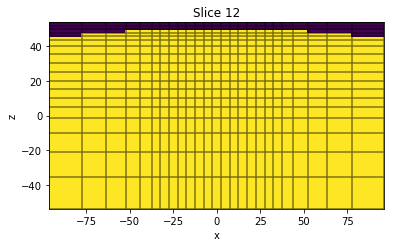

In [3]:
# Show active model and obs
m = np.ones(nC)

model = actvMap*m

axs = plt.subplot()
mesh.plotSlice(model, normal='Y', ax=axs, ind=int(mesh.vnC[1]/2), grid=True)
axs.set_aspect('equal')

In [4]:
# Find the index of the 1D model associated with each receivers
inCell = Utils.closestPoints(mesh, rxLoc).tolist()

model = model.reshape(mesh.vnC, order='F')

ijkTop = []
subxy = []
for sub in inCell:
    
    ij = np.unravel_index(sub, mesh.vnC, 'F')[:2]
    
    # Fetch the first active
    ijk = np.r_[ij, np.argmax(model[ij[0],ij[1],:]<1)]
    ijkTop += [ijk]
    subxy += [np.ravel_multi_index(ij,dims=mesh.vnC[:2], order='F')]

In [5]:
# For tester, paint different value in model
for col in ijkTop:
    model[col[0], col[1], :col[2]] = 0

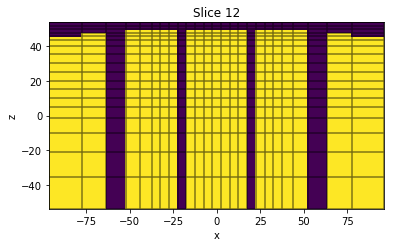

In [6]:
axs = plt.subplot()
mesh.plotSlice(model, normal='Y', ax=axs, ind=int(mesh.vnC[1]/2), grid=True)
axs.set_aspect('equal')

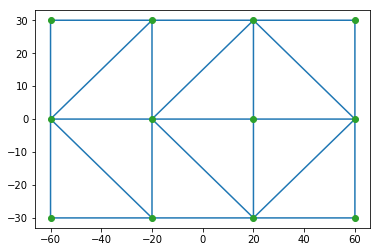

In [7]:
# Create Delauny triangulation to find closest stations
tri = sp.spatial.Delaunay(rxLoc[:,:2])
plt.triplot(rxLoc[:,0], rxLoc[:,1], tri.simplices)
plt.plot(rxLoc[:,0], rxLoc[:,1], 'o')
plt.show()

In [8]:
# Split the triangulation into connections
edges = np.r_[tri.simplices[:,:2],tri.simplices[:,1:],tri.simplices[:,[0,2]]]

# Sort and keep uniques
edges = np.sort(edges, axis=1)
edges = np.unique(edges[np.argsort(edges[:,0]),:], axis=0)


In [9]:
# Create 2D operator, dimensionless for now
nN = edges.shape[0]
nStn = rxLoc.shape[0]
stn, count = np.unique(edges[:,0], return_counts = True)

col = []
row = []
dm = []
avg = []
for ii in range(nN):
    row += [ii]*2
    col += [edges[ii,0], edges[ii,1]]
    
    scale = count[stn==edges[ii,0]][0]
    dm += [-1., 1.]
    avg += [0.5, 0.5]
    
D = sp.sparse.csr_matrix((dm, (row, col)), shape=(nN, nStn))
A = sp.sparse.csr_matrix((avg, (row, col)), shape=(nN, nStn))

# Kron vertically for nCz
Grad = sp.sparse.kron(Utils.speye(mesh.vnC[2]), D)
Avg = sp.sparse.kron(Utils.speye(mesh.vnC[2]), A)


Create a simple problem. Just a bunch of decaying cosin kernels stacked

In [10]:

N = np.ones(mesh.vnC[2])/mesh.vnC[2] * np.pi

mesh1D = Mesh.TensorMesh([N])

# Each station will have 3 kernels
nk = 3
jk = np.linspace(1., nk, nk)
p = 1.0
q = 1.1
winSize = 20

def g(k):
    return (1)**(k)*np.cos(p*(k+1)*mesh1D.vectorCCx + np.pi/8)


# Generate the sparse forward operator
F = np.zeros((nStn*nk, mesh1D.nC*nStn))
col = []
row = []
val = []
for jj in range(nStn):
    for ii in range(nk):
        row += [ii + jj*ii] * mesh1D.nC
        col += (np.r_[range(mesh1D.nC)]*nStn + jj).tolist()
        val += g(ii).tolist()
        F[row, col] = val


# Add square anomaly
mtrue = np.zeros(mesh1D.nC)
mtrue[5:8] = 0.25
mtrue = np.kron(mtrue,np.ones(nStn))

In [12]:
# Create a pseudo 2D mesh for the inversion with the 1D columns for hz
mesh2D = Mesh.TensorMesh([np.ones(nStn), mesh1D.hx])

prob = Problem.LinearProblem(mesh2D, G=F)
survey = Survey.LinearSurvey()
survey.pair(prob)

std_noise = 0.05
data = prob.fields(mtrue)
survey.dobs = data + std_noise * np.random.randn(nk*nStn)
wd = np.ones(nk*nStn) * std_noise


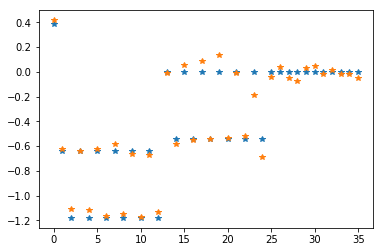

In [13]:
plt.plot(data,'*')
plt.plot(survey.dobs,'*')

In [15]:
# Now we can create the regularization using the 2D mesh
reg = Regularization.Sparse(mesh2D, mapping=Maps.IdentityMap(nP=mesh2D.nC))

# Override the gradient operator in X with the one created above
reg.regmesh._cellDiffxStencil = Grad

# Do the same for the averaging operator
reg.regmesh._aveCC2Fx = Avg

In [18]:
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./wd

betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+2)
    
opt = Optimization.ProjectedGNCG(
        maxIter=100, lower=-2., upper=2.,
        maxIterLS=20, maxIterCG=100, tolCG=1e-3,
        tolG = -1, eps=-1,
        tolF = -1, tolX= -1
    )
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
update_Jacobi = Directives.UpdatePreconditioner()

# Set the IRLS directive, penalize the lowest 25 percentile of model values
# Start with an l2-l2, then switch to lp-norms
saveDict = Directives.SaveOutputEveryIteration(save_txt=False)
IRLS = Directives.Update_IRLS(maxIRLSiter=3, minGNiter=1)

inv = Inversion.BaseInversion(
    invProb,
    directiveList=[betaest, saveDict, IRLS, update_Jacobi]
)

# Run inversion
mrec = inv.run(np.ones(mesh2D.nC)*1e-3)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.50e+05  2.49e+03  0.00e+00  2.49e+03    2.93e+01      0              
   1  1.25e+05  2.39e+03  1.89e-04  2.41e+03    2.94e+01      0              
   2  6.26e+04  2.31e+03  6.99e-04  2.35e+03    2.94e+01      0   Skip BFGS  
   3  3.13e+04  2.15e+03  2.48e-03  2.23e+03    2.93e+01      0   Skip BFGS  
   4  1.57e+04  1.91e+03  8.35e-03  2.04e+03    2.92e+01      0   Skip BFGS  
   5  7.83e+03  1.53e+03  2.58e-02  1.74e+03    2.91e+01      0   Skip 

(<matplotlib.collections.QuadMesh at 0x2c0fadaa128>,)

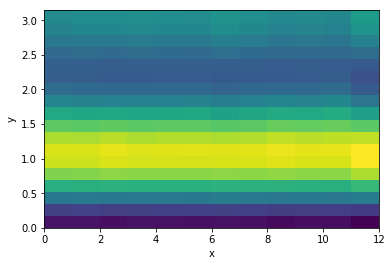

In [19]:
mesh2D.plotImage(mrec)